## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:

        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
from IPython.core.debugger import set_trace

In [2]:
# from <TC_Env> import <TicTacToe> - import your class from environment file
import collections
import numpy as np
import random
import pickle
import time
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

In [3]:
from TCGame_Env1 import TicTacToe
env = TicTacToe()

In [4]:
env.state

[nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [5]:
# agent_actions, env_actions = env.action_space([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
# agent_actions, env_actions

In [6]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):
    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [7]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [8]:
# valid_actions([7, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 2])

In [9]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys(): # or len(Q_dict[state1].keys())==0:
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [10]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
# -epsilon value(num_episodes)
# -genrate a random z
# -z>e:
#     exploitation
#     q-values: best
# else:
#     exploration
#     random action

def get_random_action_agent(state):
    agent_action_space = [x for x in env.action_space(state)[0]]
    action = tuple(np.asarray(agent_action_space)[np.random.choice(len(agent_action_space), 1)][0])
    return action

def epsilon_greedy(state, time, min_epsilon=0.001, max_epsilon=1.0):
    
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001 * time)
        
    z = np.random.random()
        
    if z > epsilon:
        action = max(Q_dict[Q_state(state)],key=Q_dict[Q_state(state)].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        action = get_random_action_agent(state)   #Exploration: randomly choosing an action
    
    return action


In [11]:
# sample_state = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
# max(Q_dict[Q_state(sample_state)],key=Q_dict[Q_state(sample_state)].get)

In [12]:
# env.allowed_values([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])[0]

In [13]:
# [x for x in env.action_space([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])[0]]

In [14]:
# agent_action_space = [x for x in env.action_space([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])[0]]
# tuple(np.asarray(agent_action_space)[np.random.choice(len(agent_action_space), 1)][0])

#### Tracking the state-action pairs for checking convergence - write your code here

In [15]:
states_tracked = [
    ('7-x-x-2-x-x-x-x-x', (1, 3)),
    ('x-x-2-x-x-x-x-x-5', (0, 9)),
    ('x-x-4-x-x-x-x-x-5', (4, 9)),
    ('x-x-x-9-4-x-x-x-x', (0, 5))
]

In [16]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)
rewards_tracked = {states_tracked[0][0]: [],
                   states_tracked[1][0]: [],
                   states_tracked[2][0]: [],
                   states_tracked[3][0]: []}
episode_rewards_tracked = {}
accumulated_rewards_tracked = {}

In [17]:
# Initialise states to be tracked
# This function will initialise the Q-values which need to be tracked for checking convergence
def initialise_tracking_states():
    sample_q_values = states_tracked
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode   
  
  
  

In [18]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open('../artifacts/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [19]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [20]:
initialise_tracking_states()

In [21]:
# States_track

#### Define hyperparameters  ---write your code here

In [22]:
#Defining parameters for the experiment

EPISODES = 1000000
# STEPS = 30                 
LR = 0.1                   #learning rate
GAMMA = 0.91

threshold = 2000       #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
policy_threshold = 30000    #every these many episodes, the Q-dict will be updated

### Q-update loop ---write your code here

In [23]:
# start_time = time.time()

# for episode in range(EPISODES):
#     ##### Start writing your code from the next line
#     - Init state
#     env = tictac .. 
#     while not terminal:
#         - add_to_dict(state)
#         - E-greedy - action
#         reward,next_state,terminal_flag = env.step(state , action)
        
#         q[s][a] += LR((r +gamma*(max(q[s']))  -q[s][a] )
#         if terminal:
#           q[s][a] += LR(r - q[s][a])
    
# elapsed_time = time.time() - start_time
# save_obj(States_track,'States_tracked')
# save_obj(Q_dict,'Policy')


start_time = time.time()
accumulated_total_reward = 0
for episode in tqdm(range(EPISODES)):
    
    env = TicTacToe()      #creating an instance of the class
    #this initialises the state back to some initial value which is required for every new episode
    #this also initialises all parameters
    
    initial_state = env.state #for the purpose of tracking reward
    curr_state = env.state
    terminal = False
    total_reward = 0
    
    # initial run
    add_to_dict(curr_state)
    curr_action = get_random_action_agent(curr_state)
    next_state, _, _ = env.step(curr_state, curr_action)
    add_to_dict(next_state)
    curr_state = next_state
    
    while not terminal:    #the episode will run till terminal state
        
        # set_trace()
        
        # add_to_dict(curr_state)    
        curr_action = epsilon_greedy(curr_state, episode)
        next_state, reward, terminal = env.step(curr_state, curr_action)
        
        add_to_dict(next_state)
        
        # UPDATE RULE
        if terminal:
            Q_dict[Q_state(curr_state)][curr_action] += LR * (reward - Q_dict[Q_state(curr_state)][curr_action])
        else:
            max_next = max(Q_dict[Q_state(next_state)],key=Q_dict[Q_state(next_state)].get)   #this gets the action corresponding to max q-value of next state
            Q_dict[Q_state(curr_state)][curr_action] += LR * ((reward + (GAMMA*(Q_dict[Q_state(next_state)][max_next]))) - Q_dict[Q_state(curr_state)][curr_action] ) 
            
        curr_state = next_state       #state(t) became state(t-1)
        total_reward += reward

    accumulated_total_reward += total_reward
    
    #TRACKING REWARDS
    episode_rewards_tracked[episode] = total_reward
    
    for track_state in rewards_tracked.keys():     #storing rewards
        rewards_tracked[track_state].append(total_reward)

    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_obj(rewards_tracked,'Rewards')   
        save_obj(episode_rewards_tracked,'Episodic_Rewards')
    
    #TRACKING Q-VALUES
    if (episode == threshold-1):        #at the 1999th episode
        initialise_tracking_states()
      
    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')   
    
    #SAVING POLICY
    if ((episode+1)% policy_threshold ) == 0:  #every 30000th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')    
        
    if ((episode+1) % 10000) == 0:   #every 10000th episode  
        accumulated_rewards_tracked[episode+1] = accumulated_total_reward / (episode+1)
        print(f'Episode: {episode+1}, Average Rewards: {accumulated_rewards_tracked[episode+1]}')        
        
    

elapsed_time = time.time() - start_time
save_obj(rewards_tracked,'Rewards')
save_obj(episode_rewards_tracked,'Episodic_Rewards')
save_obj(accumulated_rewards_tracked,'Average_Acculmulated_Rewards')
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

  0%|          | 0/1000000 [00:00<?, ?it/s]

Episode: 10000, Average Rewards: 3.0155
Episode: 20000, Average Rewards: 2.96175
Episode: 30000, Average Rewards: 2.9711333333333334
Episode: 40000, Average Rewards: 2.947775
Episode: 50000, Average Rewards: 2.95596
Episode: 60000, Average Rewards: 2.96705
Episode: 70000, Average Rewards: 2.9692857142857143
Episode: 80000, Average Rewards: 2.9734625
Episode: 90000, Average Rewards: 2.973988888888889
Episode: 100000, Average Rewards: 2.9809
Episode: 110000, Average Rewards: 2.9872727272727273
Episode: 120000, Average Rewards: 2.9838
Episode: 130000, Average Rewards: 2.9852615384615384
Episode: 140000, Average Rewards: 2.9887214285714285
Episode: 150000, Average Rewards: 2.993
Episode: 160000, Average Rewards: 2.99414375
Episode: 170000, Average Rewards: 2.9958470588235295
Episode: 180000, Average Rewards: 3.0046222222222223
Episode: 190000, Average Rewards: 3.004973684210526
Episode: 200000, Average Rewards: 3.00282
Episode: 210000, Average Rewards: 3.0074666666666667
Episode: 220000, A

#### Check the Q-dictionary

In [24]:
def get_top_qvalues(Q_dict, thresh=0.5):
    top_values = []
    for state in Q_dict.keys():
        for action, q_value in Q_dict[state].items():
            if q_value > thresh:
                top_values.append((state, action, q_value))
    return top_values

In [25]:
# Q_dict

In [26]:
# max(Q_dict['x-x-x-x-x-x-x-x-x'],key=Q_dict['x-x-x-x-x-x-x-x-x'].get)

In [27]:
# {k: v for k, v in sorted(Q_dict.items(), key=lambda item: item[1])}

In [28]:
len(Q_dict)

1485426

In [29]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

In [43]:
top_qvalues = get_top_qvalues(Q_dict, thresh=9)
top_qvalues
# [(s,a) for s,a,q in top_qvalues]

[('x-x-x-x-4-8-9-x-1', (3, 3), 9.01522909781639),
 ('x-x-4-9-x-x-5-2-x', (0, 1), 9.353891811077332),
 ('x-2-x-x-5-x-6-x-3', (0, 7), 9.476652366972639),
 ('x-x-x-x-9-2-8-x-5', (0, 1), 9.202335569231275),
 ('5-x-9-x-x-4-x-2-x', (1, 1), 9.01522909781639),
 ('x-x-x-x-3-8-6-x-7', (0, 5), 9.113706188034751),
 ('x-x-x-9-x-2-5-8-x', (0, 1), 9.113706188034751),
 ('x-x-x-x-5-x-8-2-1', (0, 9), 9.113706188034751),
 ('5-x-9-x-x-8-x-2-x', (1, 1), 9.01522909781639),
 ('x-4-x-1-8-x-5-x-x', (0, 9), 9.113706188034751),
 ('x-x-4-x-9-x-x-8-5', (0, 1), 9.528987130275375),
 ('x-x-x-9-8-x-5-2-x', (0, 1), 9.282102012308147),
 ('5-x-9-x-2-x-8-x-x', (1, 1), 9.282102012308147),
 ('x-4-x-5-3-x-2-x-x', (5, 7), 9.202335569231275),
 ('5-9-x-x-x-x-6-x-4', (2, 1), 9.353891811077332),
 ('9-5-x-6-x-x-2-x-x', (2, 1), 9.202335569231275),
 ('5-x-9-x-2-4-x-x-x', (1, 1), 9.202335569231275),
 ('x-4-2-x-9-x-x-x-1', (0, 5), 9.01522909781639),
 ('3-x-7-x-x-x-8-x-6', (7, 1), 9.418502629969598),
 ('x-8-6-x-5-x-x-x-3', (0, 1), 9.11

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [44]:
# States_track

In [32]:
# rewards_tracked

In [33]:
# Write the code for plotting the graphs for state-action pairs tracked

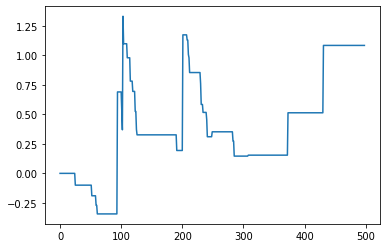

In [34]:
plot_values = States_track[states_tracked[0][0]][states_tracked[0][1]];
plt.plot(np.arange(len(plot_values)), plot_values);

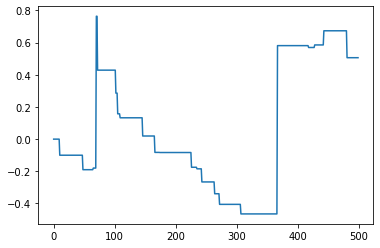

In [35]:
plot_values = States_track[states_tracked[1][0]][states_tracked[1][1]];
plt.plot(np.arange(len(plot_values)), plot_values);

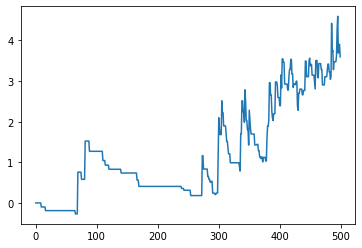

In [36]:
plot_values = States_track[states_tracked[2][0]][states_tracked[2][1]]
plt.plot(np.arange(len(plot_values)), plot_values);

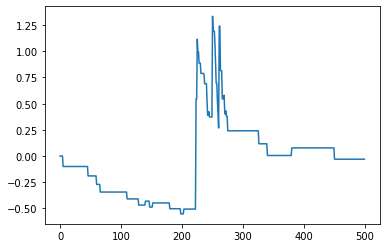

In [37]:
plot_values = States_track[states_tracked[3][0]][states_tracked[3][1]]
plt.plot(np.arange(len(plot_values)), plot_values);

In [38]:
# plt.plot(episode_rewards_tracked.keys(), episode_rewards_tracked.values())

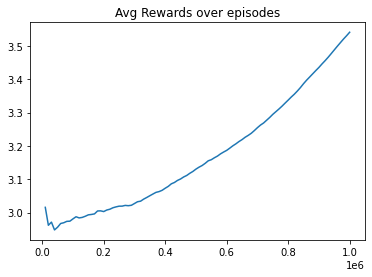

In [39]:
plt.plot(accumulated_rewards_tracked.keys(), accumulated_rewards_tracked.values());
plt.title('Avg Rewards over episodes');

In [40]:
# episode_rewards_tracked

### Epsilon - decay check

In [41]:
# max_epsilon = 1.0
# min_epsilon = 0.001
# time = np.arange(0,5000000)
# epsilon = []
# for i in range(0,5000000):
#     epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

In [42]:
# plt.plot(time, epsilon)
# plt.show()